<a href="https://colab.research.google.com/github/kharyal/GANs/blob/master/GANwithLabels/GAN_with_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from utils import Logger

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size=90
train = dsets.MNIST(root = './data', train = True,
                        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ]), download = True)

test = dsets.MNIST(root = './data', train = False,
                       transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ]))
train_batch = torch.utils.data.DataLoader(dataset = train,
                                             batch_size = batch_size,
                         
                                             shuffle = True)

test_batch = torch.utils.data.DataLoader(dataset = test,
                                      batch_size = batch_size, 
                                      shuffle = False)

0it [00:00, ?it/s]

9920512it [00:02, 3790696.99it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 55439.39it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 929709.49it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 21301.43it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(28, 28)

In [0]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier,self).__init__()
        ip=784
        op=10

        self.Layer1=nn.Sequential(
            nn.Linear(ip,1000),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        self.Layer2=nn.Sequential(
            nn.Linear(1000,500),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        self.Layer3=nn.Sequential(
            nn.Linear(500,10),
            nn.Sigmoid(),
        )
    
    def forward(self,x):
        x=self.Layer1(x)
        x=self.Layer2(x)
        x=self.Layer3(x)
        return x

In [5]:
classifyNet=classifier().to(device)
lossclassify=nn.CrossEntropyLoss()
classifyNet.load_state_dict(torch.load('./classifier'))
classifyNet.eval()

classifier(
  (Layer1): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
  )
  (Layer2): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
  )
  (Layer3): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=True)
    (1): Sigmoid()
  )
)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        ip=784
        op=1

        self.layer1=nn.Sequential(
            nn.Linear(ip,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.layer2=nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        # self.layer3=nn.Sequential(
        #     nn.Linear(512,256),
        #     nn.LeakyReLU(0.2),
        #     nn.Dropout(0.3)
        # )

        self.layerOp=nn.Sequential(
            nn.Linear(512,op),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        # x=self.layer3(x)
        x=self.layerOp(x)
        return x

In [0]:
class generator(nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        ip=100
        op=784

        self.layer1=nn.Sequential(
            nn.Linear(ip,256),
            nn.LeakyReLU()
        )

        self.layer2=nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU()
        )

        self.layer3=nn.Sequential(
            nn.Linear(512,1024),
            nn.LeakyReLU()
        )

        self.layerlb1=nn.Sequential(
            nn.Linear(1,10),
            nn.LeakyReLU()
        )

        self.layerlb2=nn.Sequential(
            nn.Linear(10,100),
            nn.LeakyReLU()
        )

        self.layerlb3=nn.Sequential(
            nn.Linear(100,512),
            nn.LeakyReLU()
        )

        self.layerOp=nn.Sequential(
            nn.Linear(1024,op),
            nn.Tanh()
        )
        self.relu=nn.LeakyReLU()

    def forward(self,x,lb):
        x=self.layer1(x)
        x=self.layer2(x)
        y=self.layerlb1(lb)
        y=self.layerlb2(y)
        y=self.layerlb3(y)
        x=self.relu(self.layer3(x+y))
        x=self.layerOp(x)
        return x       

In [0]:
discriminatorNet=discriminator()
generatorNet=generator()
# if torch.cuda.is_available():
#     discriminatorNet.cuda()
#     generatorNet.cuda()
optimizer_d = torch.optim.Adam(discriminatorNet.parameters(), lr=0.0002)
optimizer_g = torch.optim.Adam(generatorNet.parameters(), lr=0.0002)
loss=nn.BCELoss()
newLoss=nn.NLLLoss()

In [0]:
def ones_target(size):
    data = Variable(torch.ones(size, 1)).to(device)
    return data

def zeros_target(size):
    data = Variable(torch.zeros(size, 1)).to(device)
    return data

In [0]:
def trainDiscriminator(real_data, generated_data, optimizer):
    N=real_data.size(0)
    optimizer.zero_grad()

    ### real data
    opReal=discriminatorNet(real_data).to(device)
    errorR= loss(opReal,ones_target(N)).to(device)
    errorR.backward(retain_graph=True)
    # print('opR ',opReal)
    # optimizer.step()

    ### generated data
    opGen=discriminatorNet(generated_data).to(device)
    errorG= loss(opGen,zeros_target(N)).to(device)
    errorG.backward()
    # print('opG ',opGen)

    optimizer.step()
    return errorR+errorG, opReal, opGen 

In [0]:
def trainGenerator(optimizer, noise, lab):
    N=noise.size(0)
    optimizer.zero_grad()
    randlab=Variable(torch.randint(low=0,high=10,size=(1,))).to(device)
    generatedData=generatorNet(noise,randlab.float()).to(device)
    op=discriminatorNet(generatedData).to(device)
    error=loss(op,ones_target(N)).to(device)
    error.backward()

    randlab=Variable(torch.randint(low=0,high=10,size=(1,))).to(device)
    generatedData=generatorNet(noise,randlab.float()).to(device)
    y=classifyNet(generatedData).to(device)
    # print(y.shape)
    target=Variable(randlab.item()*ones_target(N).long()).reshape(N).to(device)
    # print(target[0])
    # print(len(y))
    err=lossclassify(y.float(),target)
    err.backward()
    optimizer.step()    
    return error

0
LABEL GIVEN:  tensor([4], device='cuda:0')
LABEL PREDICTED:  torch.return_types.max(
values=tensor([1.], device='cuda:0'),
indices=tensor([628], device='cuda:0'))


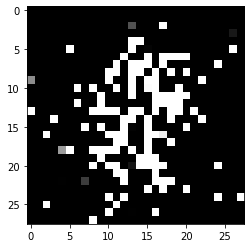

epoch G error:  tensor(2745.8391, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(360.1322, device='cuda:0', grad_fn=<AddBackward0>)
1
epoch G error:  tensor(5104.0557, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(30.1525, device='cuda:0', grad_fn=<AddBackward0>)
2
epoch G error:  tensor(4067.8770, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(419.7989, device='cuda:0', grad_fn=<AddBackward0>)
3
epoch G error:  tensor(1037.4142, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(799.8028, device='cuda:0', grad_fn=<AddBackward0>)
4
epoch G error:  tensor(1449.1868, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(391.0601, device='cuda:0', grad_fn=<AddBackward0>)
5
epoch G error:  tensor(2106.2729, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(256.9132, device='cuda:0', grad_fn=<AddBackward0>)
6
epoch G error:  tensor(2117.0474, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

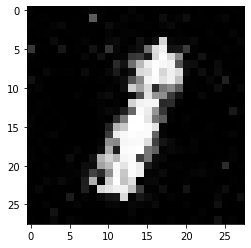

epoch G error:  tensor(2175.3779, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(303.2980, device='cuda:0', grad_fn=<AddBackward0>)
11
epoch G error:  tensor(2344.2683, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(263.7489, device='cuda:0', grad_fn=<AddBackward0>)
12
epoch G error:  tensor(2247.3496, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(289.3344, device='cuda:0', grad_fn=<AddBackward0>)
13
epoch G error:  tensor(2202.3010, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(284.8908, device='cuda:0', grad_fn=<AddBackward0>)
14
epoch G error:  tensor(1920.2889, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(336.6754, device='cuda:0', grad_fn=<AddBackward0>)
15
epoch G error:  tensor(2021.3369, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(331.7550, device='cuda:0', grad_fn=<AddBackward0>)
16
epoch G error:  tensor(2012.9177, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error

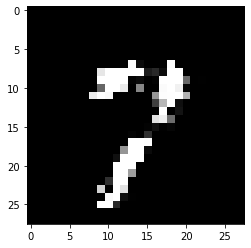

epoch G error:  tensor(1590.4047, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(414.6684, device='cuda:0', grad_fn=<AddBackward0>)
21
epoch G error:  tensor(1504.0243, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(427.2148, device='cuda:0', grad_fn=<AddBackward0>)
22
epoch G error:  tensor(1449.3600, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(464.1426, device='cuda:0', grad_fn=<AddBackward0>)
23
epoch G error:  tensor(1476.3436, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(458.2817, device='cuda:0', grad_fn=<AddBackward0>)
24
epoch G error:  tensor(1329.7983, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(491.7799, device='cuda:0', grad_fn=<AddBackward0>)
25
epoch G error:  tensor(1317.3810, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(507.4990, device='cuda:0', grad_fn=<AddBackward0>)
26
epoch G error:  tensor(1253.0438, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error

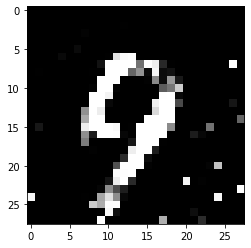

epoch G error:  tensor(1104.7489, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(580.5854, device='cuda:0', grad_fn=<AddBackward0>)
31
epoch G error:  tensor(1121.1333, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(588.1790, device='cuda:0', grad_fn=<AddBackward0>)
32
epoch G error:  tensor(1146.1316, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(601.8317, device='cuda:0', grad_fn=<AddBackward0>)
33
epoch G error:  tensor(1171.7855, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(607.9919, device='cuda:0', grad_fn=<AddBackward0>)
34
epoch G error:  tensor(1057.6438, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(589.6005, device='cuda:0', grad_fn=<AddBackward0>)
35
epoch G error:  tensor(1081.0176, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(615.4735, device='cuda:0', grad_fn=<AddBackward0>)
36
epoch G error:  tensor(1038.3583, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error

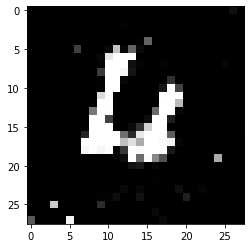

epoch G error:  tensor(987.0765, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(646.4091, device='cuda:0', grad_fn=<AddBackward0>)
41
epoch G error:  tensor(982.2646, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(641.3867, device='cuda:0', grad_fn=<AddBackward0>)
42
epoch G error:  tensor(979.8881, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(663.6335, device='cuda:0', grad_fn=<AddBackward0>)
43
epoch G error:  tensor(917.2868, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(658.0029, device='cuda:0', grad_fn=<AddBackward0>)
44
epoch G error:  tensor(940.1315, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(656.8806, device='cuda:0', grad_fn=<AddBackward0>)
45
epoch G error:  tensor(924.1599, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(687.0741, device='cuda:0', grad_fn=<AddBackward0>)
46
epoch G error:  tensor(900.9474, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

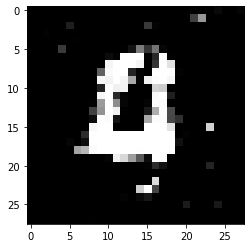

epoch G error:  tensor(890.2090, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(696.9751, device='cuda:0', grad_fn=<AddBackward0>)
51
epoch G error:  tensor(878.6635, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(705.3053, device='cuda:0', grad_fn=<AddBackward0>)
52
epoch G error:  tensor(846.1925, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(714.1520, device='cuda:0', grad_fn=<AddBackward0>)
53
epoch G error:  tensor(842.3472, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(714.1223, device='cuda:0', grad_fn=<AddBackward0>)
54
epoch G error:  tensor(845.4714, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(708.9028, device='cuda:0', grad_fn=<AddBackward0>)
55
epoch G error:  tensor(809.5822, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(719.9880, device='cuda:0', grad_fn=<AddBackward0>)
56
epoch G error:  tensor(838.0792, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

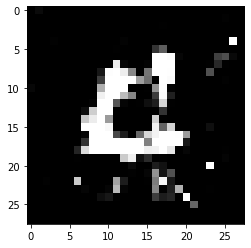

epoch G error:  tensor(791.7120, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(735.6982, device='cuda:0', grad_fn=<AddBackward0>)
61
epoch G error:  tensor(773.7803, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(728.3361, device='cuda:0', grad_fn=<AddBackward0>)
62
epoch G error:  tensor(779.7994, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(741.3046, device='cuda:0', grad_fn=<AddBackward0>)
63
epoch G error:  tensor(787.5145, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(729.9650, device='cuda:0', grad_fn=<AddBackward0>)
64
epoch G error:  tensor(787.4741, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(736.3455, device='cuda:0', grad_fn=<AddBackward0>)
65
epoch G error:  tensor(794.8466, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(732.8029, device='cuda:0', grad_fn=<AddBackward0>)
66
epoch G error:  tensor(782.8473, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

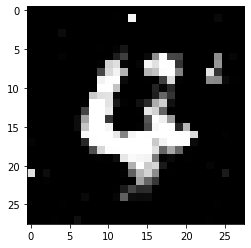

epoch G error:  tensor(774.1242, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(749.8207, device='cuda:0', grad_fn=<AddBackward0>)
71
epoch G error:  tensor(773.0444, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(742.2073, device='cuda:0', grad_fn=<AddBackward0>)
72
epoch G error:  tensor(780.4959, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(748.6806, device='cuda:0', grad_fn=<AddBackward0>)
73
epoch G error:  tensor(758.1069, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(757.8055, device='cuda:0', grad_fn=<AddBackward0>)
74
epoch G error:  tensor(756.6225, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(768.7535, device='cuda:0', grad_fn=<AddBackward0>)
75
epoch G error:  tensor(748.5422, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(781.9208, device='cuda:0', grad_fn=<AddBackward0>)
76
epoch G error:  tensor(714.2602, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

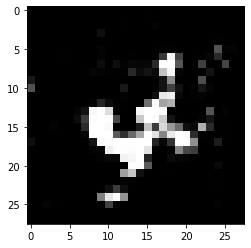

epoch G error:  tensor(694.2168, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(810.0197, device='cuda:0', grad_fn=<AddBackward0>)
81
epoch G error:  tensor(674.1510, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(815.7286, device='cuda:0', grad_fn=<AddBackward0>)
82
epoch G error:  tensor(666.2656, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(814.0885, device='cuda:0', grad_fn=<AddBackward0>)
83
epoch G error:  tensor(671.5649, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(824.4357, device='cuda:0', grad_fn=<AddBackward0>)
84
epoch G error:  tensor(650.8882, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(824.8849, device='cuda:0', grad_fn=<AddBackward0>)
85
epoch G error:  tensor(669.0235, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(814.7926, device='cuda:0', grad_fn=<AddBackward0>)
86
epoch G error:  tensor(680.1816, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

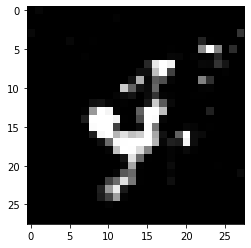

epoch G error:  tensor(641.4417, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(832.2088, device='cuda:0', grad_fn=<AddBackward0>)
91
epoch G error:  tensor(638.3430, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(829.6225, device='cuda:0', grad_fn=<AddBackward0>)
92
epoch G error:  tensor(660.7601, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(834.7407, device='cuda:0', grad_fn=<AddBackward0>)
93
epoch G error:  tensor(624.2410, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(835.6778, device='cuda:0', grad_fn=<AddBackward0>)
94
epoch G error:  tensor(651.3713, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(841.2631, device='cuda:0', grad_fn=<AddBackward0>)
95
epoch G error:  tensor(632.3500, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(834.9451, device='cuda:0', grad_fn=<AddBackward0>)
96
epoch G error:  tensor(619.9699, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tens

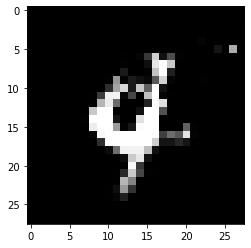

epoch G error:  tensor(628.7620, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(842.7175, device='cuda:0', grad_fn=<AddBackward0>)
101
epoch G error:  tensor(624.6737, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(834.8361, device='cuda:0', grad_fn=<AddBackward0>)
102
epoch G error:  tensor(617.7888, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(838.6313, device='cuda:0', grad_fn=<AddBackward0>)
103
epoch G error:  tensor(624.2320, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(847.7716, device='cuda:0', grad_fn=<AddBackward0>)
104
epoch G error:  tensor(605.5580, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(848.3054, device='cuda:0', grad_fn=<AddBackward0>)
105
epoch G error:  tensor(609.7537, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(840.1028, device='cuda:0', grad_fn=<AddBackward0>)
106
epoch G error:  tensor(592.6614, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

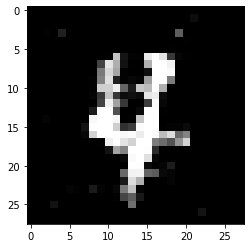

epoch G error:  tensor(604.7971, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(851.1564, device='cuda:0', grad_fn=<AddBackward0>)
111
epoch G error:  tensor(590.7387, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(859.3157, device='cuda:0', grad_fn=<AddBackward0>)
112
epoch G error:  tensor(592.6663, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(852.5328, device='cuda:0', grad_fn=<AddBackward0>)
113
epoch G error:  tensor(605.4932, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(853.7721, device='cuda:0', grad_fn=<AddBackward0>)
114
epoch G error:  tensor(587.2313, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(859.1909, device='cuda:0', grad_fn=<AddBackward0>)
115
epoch G error:  tensor(606.0485, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(855.0750, device='cuda:0', grad_fn=<AddBackward0>)
116
epoch G error:  tensor(583.8892, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

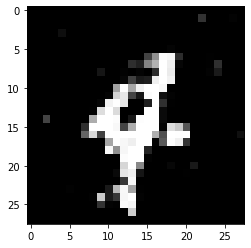

epoch G error:  tensor(608.8113, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(866.6714, device='cuda:0', grad_fn=<AddBackward0>)
121
epoch G error:  tensor(587.6094, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(860.4031, device='cuda:0', grad_fn=<AddBackward0>)
122
epoch G error:  tensor(575.4376, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(854.4439, device='cuda:0', grad_fn=<AddBackward0>)
123
epoch G error:  tensor(576.6203, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(857.9030, device='cuda:0', grad_fn=<AddBackward0>)
124
epoch G error:  tensor(568.3423, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(866.2615, device='cuda:0', grad_fn=<AddBackward0>)
125
epoch G error:  tensor(585.2100, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(865.1667, device='cuda:0', grad_fn=<AddBackward0>)
126
epoch G error:  tensor(615.4997, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

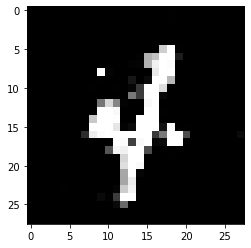

epoch G error:  tensor(579.3036, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(865.5681, device='cuda:0', grad_fn=<AddBackward0>)
131
epoch G error:  tensor(611.3108, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(855.6731, device='cuda:0', grad_fn=<AddBackward0>)
132
epoch G error:  tensor(575.8461, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(861.1246, device='cuda:0', grad_fn=<AddBackward0>)
133
epoch G error:  tensor(589.4321, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(861.3096, device='cuda:0', grad_fn=<AddBackward0>)
134
epoch G error:  tensor(583.4435, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(863.0606, device='cuda:0', grad_fn=<AddBackward0>)
135
epoch G error:  tensor(592.8600, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(858.6220, device='cuda:0', grad_fn=<AddBackward0>)
136
epoch G error:  tensor(568.9055, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

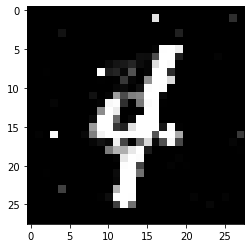

epoch G error:  tensor(566.3101, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(871.5536, device='cuda:0', grad_fn=<AddBackward0>)
141
epoch G error:  tensor(567.8121, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(867.0706, device='cuda:0', grad_fn=<AddBackward0>)
142
epoch G error:  tensor(566.3365, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(869.9769, device='cuda:0', grad_fn=<AddBackward0>)
143
epoch G error:  tensor(576.2682, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(865.8766, device='cuda:0', grad_fn=<AddBackward0>)
144
epoch G error:  tensor(565.2098, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(870.7792, device='cuda:0', grad_fn=<AddBackward0>)
145
epoch G error:  tensor(557.0080, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(872.7993, device='cuda:0', grad_fn=<AddBackward0>)
146
epoch G error:  tensor(556.5760, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

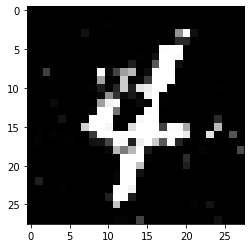

epoch G error:  tensor(554.8984, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(874.8821, device='cuda:0', grad_fn=<AddBackward0>)
151
epoch G error:  tensor(560.8436, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(879.7322, device='cuda:0', grad_fn=<AddBackward0>)
152
epoch G error:  tensor(568.2728, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(875.9649, device='cuda:0', grad_fn=<AddBackward0>)
153
epoch G error:  tensor(557.6671, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(873.7538, device='cuda:0', grad_fn=<AddBackward0>)
154
epoch G error:  tensor(555.2896, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(876.5966, device='cuda:0', grad_fn=<AddBackward0>)
155
epoch G error:  tensor(563.0627, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(871.8222, device='cuda:0', grad_fn=<AddBackward0>)
156
epoch G error:  tensor(557.1658, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

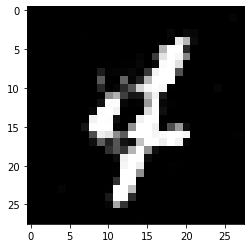

epoch G error:  tensor(570.2645, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(881.7695, device='cuda:0', grad_fn=<AddBackward0>)
161
epoch G error:  tensor(546.2160, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(875.4545, device='cuda:0', grad_fn=<AddBackward0>)
162
epoch G error:  tensor(566.0884, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(876.3005, device='cuda:0', grad_fn=<AddBackward0>)
163
epoch G error:  tensor(554.3085, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(874.6216, device='cuda:0', grad_fn=<AddBackward0>)
164
epoch G error:  tensor(565.9134, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(878.2933, device='cuda:0', grad_fn=<AddBackward0>)
165
epoch G error:  tensor(569.8898, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(872.8760, device='cuda:0', grad_fn=<AddBackward0>)
166
epoch G error:  tensor(553.1141, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

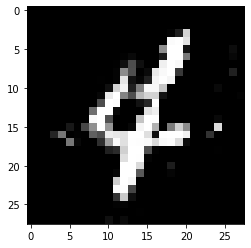

epoch G error:  tensor(551.5792, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(875.9980, device='cuda:0', grad_fn=<AddBackward0>)
171
epoch G error:  tensor(550.1167, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(882.2462, device='cuda:0', grad_fn=<AddBackward0>)
172
epoch G error:  tensor(559.4735, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(878.0051, device='cuda:0', grad_fn=<AddBackward0>)
173
epoch G error:  tensor(575.6418, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(872.1835, device='cuda:0', grad_fn=<AddBackward0>)
174
epoch G error:  tensor(557.0070, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(883.3514, device='cuda:0', grad_fn=<AddBackward0>)
175
epoch G error:  tensor(565.6305, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(875.6673, device='cuda:0', grad_fn=<AddBackward0>)
176
epoch G error:  tensor(562.5738, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

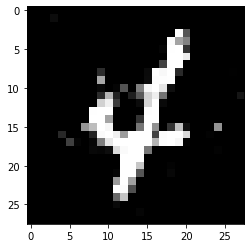

epoch G error:  tensor(553.7518, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(887.7207, device='cuda:0', grad_fn=<AddBackward0>)
181
epoch G error:  tensor(540.3781, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(881.7598, device='cuda:0', grad_fn=<AddBackward0>)
182
epoch G error:  tensor(573.2172, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(879.1302, device='cuda:0', grad_fn=<AddBackward0>)
183
epoch G error:  tensor(553.9785, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(877.7075, device='cuda:0', grad_fn=<AddBackward0>)
184
epoch G error:  tensor(548.8443, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(875.9346, device='cuda:0', grad_fn=<AddBackward0>)
185
epoch G error:  tensor(555.4066, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(874.6629, device='cuda:0', grad_fn=<AddBackward0>)
186
epoch G error:  tensor(559.4199, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

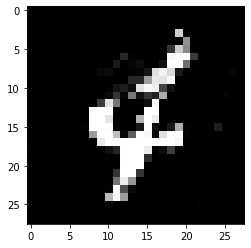

epoch G error:  tensor(552.6123, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(877.7386, device='cuda:0', grad_fn=<AddBackward0>)
191
epoch G error:  tensor(542.8184, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(882.9836, device='cuda:0', grad_fn=<AddBackward0>)
192
epoch G error:  tensor(548.7923, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(877.1351, device='cuda:0', grad_fn=<AddBackward0>)
193
epoch G error:  tensor(554.3868, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(884.7441, device='cuda:0', grad_fn=<AddBackward0>)
194
epoch G error:  tensor(541.0090, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(885.5939, device='cuda:0', grad_fn=<AddBackward0>)
195
epoch G error:  tensor(549.8872, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(882.5396, device='cuda:0', grad_fn=<AddBackward0>)
196
epoch G error:  tensor(547.5009, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:

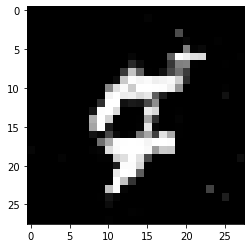

epoch G error:  tensor(537.4792, device='cuda:0', grad_fn=<AddBackward0>)
epoch D error:  tensor(881.4427, device='cuda:0', grad_fn=<AddBackward0>)


In [12]:
epochs=201
op=[]
# logger = Logger(model_name='VGAN', data_name='MNIST')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generatorNet=generatorNet.to(device)
discriminatorNet=discriminatorNet.to(device)
randtest=Variable(torch.randn(1, 100)).to(device)
randLabel=Variable(torch.randint(low=0,high=10,size=(1,))).to(device)
totalGerr=0
totalDerr=0
for epoch in range(epochs):
    print(epoch)
    totalGerr=0
    totalDerr=0
    for n_batch, (real_batch,_) in enumerate(train_batch):
        # n_batch=n_batch.to(device)
        real_batch=real_batch.to(device)
        N=real_batch.size(0)

        # print('Discriminator part')
        real_data = Variable(images_to_vectors(real_batch))
        rand=Variable(torch.randn(N, 100)).to(device)
        randlab=Variable(torch.randint(low=0,high=10,size=(1,))).to(device)
        gen=generatorNet(rand,randlab.float()).detach()
        # op=vectors_to_images(gen)
        # print(op.shape)
        # plt.imshow(op)
        # plt.show()
        gen=gen.to(device)
        d_error, d_pred_real, d_pred_fake = trainDiscriminator(real_data, gen, optimizer_d)
        totalDerr=totalDerr+d_error

        # print('Generator Part')
        noise=Variable(torch.randn(N, 100)).to(device)
        randlab=Variable(torch.randint(low=1,high=11,size=(N,))).to(device)
        g_error = trainGenerator(optimizer_g, noise,randlab).to(device)
        totalGerr=totalGerr+g_error
        

    if epoch%10==0:
        op=generatorNet(randtest,randLabel.float()).detach()
        print("LABEL GIVEN: ",randLabel)
        print("LABEL PREDICTED: ",torch.max(op, 1))
        op=vectors_to_images(op)
        op=op.cpu().detach().numpy()
        plt.imshow(op,cmap='gray')
        plt.show()
    print('epoch G error: ',totalGerr)
    print('epoch D error: ',totalDerr)
    # real_batch=real_batch.detach()
    #     break.to(device)
    # break

Label Given=  tensor([[0.]], device='cuda:0')
Label Predicted=  0
Label Given=  tensor([[1.]], device='cuda:0')
Label Predicted=  1
Label Given=  tensor([[2.]], device='cuda:0')
Label Predicted=  2
Label Given=  tensor([[3.]], device='cuda:0')
Label Predicted=  3
Label Given=  tensor([[4.]], device='cuda:0')
Label Predicted=  4
Label Given=  tensor([[5.]], device='cuda:0')
Label Predicted=  5
Label Given=  tensor([[6.]], device='cuda:0')
Label Predicted=  6
Label Given=  tensor([[7.]], device='cuda:0')
Label Predicted=  7
Label Given=  tensor([[8.]], device='cuda:0')
Label Predicted=  8
Label Given=  tensor([[9.]], device='cuda:0')
Label Predicted=  9


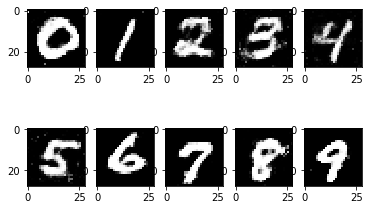

In [49]:
randtest=Variable(torch.randn(1, 100)).to(device)
fig , axs = plt.subplots(2,5) 
for i in range (10):
    maxnum=0
    maxidx=0
    labelGiven = i*ones_target(1).to(device)
    op = generatorNet(randtest,labelGiven.float()).to(device)
    op1=vectors_to_images(op).to('cpu').detach().numpy()
    axs[i//5,i%5].imshow(op1,cmap='gray')
    # plt.show()
    print('Label Given= ',labelGiven)
    pred=classifyNet(op)
    for j in range(10):
        # print(pred)
        if pred[0][j].item()>maxnum:
            maxnum=pred[0][j].item()
            maxidx=j
    print('Label Predicted= ', maxidx)

In [0]:
# torch.save(generatorNet.state_dict(),'generator')
# torch.save(discriminatorNet.state_dict(),'discriminator')